# Montar las carpetas de google drive.
# Create environment in Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Move to google drive environment
%cd /content/drive/MyDrive/TFM Comparativa Soluciones

/content/drive/MyDrive/TFM Comparativa Soluciones


In [3]:
#!unzip train.zip

# Funciones para ejecutar el código

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

from PIL import Image
from IPython.display import FileLink 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [6]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???

        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [7]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [8]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array            
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [9]:
image_path_dict = {'train': "train",
                  'val': "train" ,
                  'test': "train"}
dataframes_path = 'melanoma_without_duplicates_separated/'

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [11]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

 
def get_loss(num_classes,device):
    # Create an instance of the loss function
    # We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    #pos_weight = torch.tensor(np.ones(num_classes))
    #pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    #criterion = FocalLoss()
    return criterion

In [12]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path=dataframes_path + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [13]:
val_df = pd.read_csv(dataframes_path + "val.csv")
val_real = []
for i in range(val_df.shape[0]):
    val_real.append(val_df['target'].iloc[i])

In [14]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    import time
    start_time = time.time()
    
    #take out if just starting to train
    #checkpoint = torch.load("../input/shuffle-meta-conf-matrix/resnet_weights_12.pt")
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']

    train_losses = []
    test_losses = []
    train_auc=[]
    val_auc=[]
    train_pred = []
    train_real = []
    val_pred = []
    val_real = []
    for epoch in range(num_epochs):

        train_preds=[]
        train_targets=[]
        auc_train=[]
        loss_epoch_train=[]
        loss_epoch_test=[]
        # Run the training batches
        for inputs, features, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, features)
            outputs = torch.squeeze(outputs)
            #outputs = torch.as_tensor(outputs.tolist())
            preds = (outputs > 0).type(torch.float64)
            train_real.extend(labels.tolist())
            train_pred.extend(preds.tolist())
            
            labels = torch.squeeze(labels)
            loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
            loss_epoch_train.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        auc_train=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        #auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
        
        train_losses.append(np.mean(loss_epoch_train))
        train_auc.append(auc_train)
        
        print(f'Epoch: {epoch:2} Train Loss: {np.mean(loss_epoch_train):10.8f} AUC: {auc_train:10.8f} ')
        df_confusion = confusion_matrix(train_real, train_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        # Run the testing batches
        with torch.no_grad():
            for inputs, features, labels in tqdm(dataloaders['val']):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, features)
                #print('outputs1 ' + str(outputs))

                outputs = torch.squeeze(outputs)
                #print('outputs2 ' + str(outputs))
                preds = (outputs > 0).type(torch.float64)
                #print('labels ' + (str(labels)))
                #print('pred ' + str(preds))
                val_real.extend(labels.tolist())
                val_pred.extend(preds.tolist())
                
                #outputs = torch.as_tensor(outputs.tolist())
                #print('new outs', outputs)
                labels = torch.squeeze(labels)
                loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
                loss_epoch_test.append(loss.item())
                                          
        auc_val=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        
        test_losses.append(np.mean(loss_epoch_test))
        val_auc.append(auc_val)
        
        print(f'Epoch: {epoch} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
        df_confusion = confusion_matrix(val_real, val_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        if epoch % 5==0:
        #if epoch % 5==0:
            model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
            torch.save(model_file, dataframes_path + "Pesos VGG16DA/{}_weights_{}.pt".format(model_name, epoch))
        #epoch if just started training
        #epoch + epoch_before + 1 afterwards
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    return train_auc, val_auc, train_losses,test_losses

In [15]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'vgg16'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 64

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 200

# Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [18]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

# Train the model!
train_auc, val_auc,train_losses,test_losses  = train_model(model=model,
            dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
            scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.features.0.weight
	 cnn.features.0.bias
	 cnn.features.1.weight
	 cnn.features.1.bias
	 cnn.features.3.weight
	 cnn.features.3.bias
	 cnn.features.4.weight
	 cnn.features.4.bias
	 cnn.features.7.weight
	 cnn.features.7.bias
	 cnn.features.8.weight
	 cnn.features.8.bias
	 cnn.features.10.weight
	 cnn.features.10.bias
	 cnn.features.11.weight
	 cnn.features.11.bias
	 cnn.features.14.weight
	 cnn.features.14.bias
	 cnn.features.15.weight
	 cnn.features.15.bias
	 cnn.features.17.weight
	 cnn.features.17.bias
	 cnn.features.18.weight
	 cnn.features.18.bias
	 cnn.features.20.weight
	 cnn.features.20.bias
	 cnn.features.21.weight
	 cnn.features.21.bias
	 cnn.features.24.weight
	 cnn.features.24.bias
	 cnn.features.25.weight
	 cnn.features.25.bias
	 cnn.features.27.weight
	 cnn.features.27.bias
	 cnn.features.28.weight
	 cnn.features.28.bias
	 cnn.features.30.weight
	 cnn.features.30.bias
	 cnn.features.31.weight
	 cnn.features.31.bias
	 cnn.features.34.weight
	 cnn.feat

100%|██████████| 27/27 [01:14<00:00,  2.78s/it]


Epoch:  0 Train Loss: 0.71040176 AUC: 0.59211823 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:20<00:00,  2.89s/it]


Epoch: 0 Val Loss: 0.69925831 AUC: 0.52941176 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch:  1 Train Loss: 0.68922176 AUC: 0.76441838 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 1 Val Loss: 0.69310342 AUC: 0.64516129 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch:  2 Train Loss: 0.67247530 AUC: 0.87109375 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 2 Val Loss: 0.68325150 AUC: 0.72675522 
[[1.        0.       ]
 [0.9984127 0.0015873]]


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch:  3 Train Loss: 0.64496848 AUC: 0.85714286 
[[0.99520857 0.00479143]
 [0.94530321 0.05469679]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 3 Val Loss: 0.66561789 AUC: 0.77609108 
[[0.9481982  0.0518018 ]
 [0.86904762 0.13095238]]


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch:  4 Train Loss: 0.62201340 AUC: 0.93229167 
[[0.97632469 0.02367531]
 [0.82401902 0.17598098]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 4 Val Loss: 0.66078450 AUC: 0.76280835 
[[0.88018018 0.11981982]
 [0.71904762 0.28095238]]


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch:  5 Train Loss: 0.60023414 AUC: 0.77450980 
[[0.96279594 0.03720406]
 [0.73563218 0.26436782]]


100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 5 Val Loss: 0.65608312 AUC: 0.79506641 
[[0.84084084 0.15915916]
 [0.63174603 0.36825397]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch:  6 Train Loss: 0.59579632 AUC: 0.88235294 
[[0.9518441 0.0481559]
 [0.6701206 0.3298794]]


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 6 Val Loss: 0.65260431 AUC: 0.74762808 
[[0.82046332 0.17953668]
 [0.57687075 0.42312925]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch:  7 Train Loss: 0.60011474 AUC: 0.87254902 
[[0.94250282 0.05749718]
 [0.62381094 0.37618906]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 7 Val Loss: 0.65980009 AUC: 0.71726755 
[[0.80743243 0.19256757]
 [0.5452381  0.4547619 ]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch:  8 Train Loss: 0.59663359 AUC: 0.92063492 
[[0.93523738 0.06476262]
 [0.58448936 0.41551064]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 8 Val Loss: 0.64385933 AUC: 0.78937381 
[[0.7967968  0.2032032 ]
 [0.50846561 0.49153439]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch:  9 Train Loss: 0.58923888 AUC: 0.90935961 
[[0.93393461 0.06606539]
 [0.55588585 0.44411415]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 9 Val Loss: 0.65927130 AUC: 0.76850095 
[[0.77882883 0.22117117]
 [0.47095238 0.52904762]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 10 Train Loss: 0.58763794 AUC: 0.90686275 
[[0.93245875 0.06754125]
 [0.53053724 0.46946276]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 10 Val Loss: 0.64809981 AUC: 0.72865275 
[[0.77436527 0.22563473]
 [0.45064935 0.54935065]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 11 Train Loss: 0.59350732 AUC: 0.91568627 
[[0.93198046 0.06801954]
 [0.51476417 0.48523583]]


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch: 11 Val Loss: 0.66424412 AUC: 0.76660342 
[[0.75900901 0.24099099]
 [0.42579365 0.57420635]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 12 Train Loss: 0.58691865 AUC: 0.94330401 
[[0.93096869 0.06903131]
 [0.49766761 0.50233239]]


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch: 12 Val Loss: 0.66324580 AUC: 0.78178368 
[[0.74878725 0.25121275]
 [0.40695971 0.59304029]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 13 Train Loss: 0.58669717 AUC: 0.91170635 
[[0.92929618 0.07070382]
 [0.4811449  0.5188551 ]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 13 Val Loss: 0.68332765 AUC: 0.69639469 
[[0.73938224 0.26061776]
 [0.39863946 0.60136054]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 14 Train Loss: 0.58549625 AUC: 0.90541872 
[[0.92844795 0.07155205]
 [0.46714229 0.53285771]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 14 Val Loss: 0.65644643 AUC: 0.79316888 
[[0.73483483 0.26516517]
 [0.38730159 0.61269841]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 15 Train Loss: 0.58286237 AUC: 0.83675464 
[[0.92939684 0.07060316]
 [0.45719382 0.54280618]]


100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch: 15 Val Loss: 0.66887842 AUC: 0.83301708 
[[0.72747748 0.27252252]
 [0.37738095 0.62261905]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 16 Train Loss: 0.58456381 AUC: 0.85885886 
[[0.93049937 0.06950063]
 [0.44939498 0.55060502]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 16 Val Loss: 0.65129307 AUC: 0.77988615 
[[0.72893482 0.27106518]
 [0.37478992 0.62521008]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 17 Train Loss: 0.58056772 AUC: 0.93548387 
[[0.93122886 0.06877114]
 [0.44034879 0.55965121]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 17 Val Loss: 0.65990141 AUC: 0.72485769 
[[0.72897898 0.27102102]
 [0.37275132 0.62724868]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 18 Train Loss: 0.57713288 AUC: 0.96089932 
[[0.93235626 0.06764374]
 [0.43288066 0.56711934]]


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 18 Val Loss: 0.66584545 AUC: 0.67552182 
[[0.72475107 0.27524893]
 [0.36466165 0.63533835]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 19 Train Loss: 0.57745666 AUC: 0.97536946 
[[0.93286359 0.06713641]
 [0.4254459  0.5745541 ]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 19 Val Loss: 0.66719122 AUC: 0.75521822 
[[0.72094595 0.27905405]
 [0.35880952 0.64119048]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 20 Train Loss: 0.57451644 AUC: 0.95210166 
[[0.93385945 0.06614055]
 [0.41786988 0.58213012]]


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 20 Val Loss: 0.68083077 AUC: 0.69070209 
[[0.72157872 0.27842128]
 [0.36417234 0.63582766]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 21 Train Loss: 0.57476410 AUC: 0.95588235 
[[0.93481603 0.06518397]
 [0.41179332 0.58820668]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 21 Val Loss: 0.65996421 AUC: 0.77229602 
[[0.72051597 0.27948403]
 [0.36103896 0.63896104]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 22 Train Loss: 0.57348366 AUC: 0.93652344 
[[0.93495417 0.06504583]
 [0.4046942  0.5953058 ]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 22 Val Loss: 0.66819798 AUC: 0.76850095 
[[0.71484528 0.28515472]
 [0.35217391 0.64782609]]


100%|██████████| 27/27 [00:30<00:00,  1.14s/it]


Epoch: 23 Train Loss: 0.57413371 AUC: 0.92510121 
[[0.93550357 0.06449643]
 [0.39892985 0.60107015]]


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 23 Val Loss: 0.66786419 AUC: 0.74762808 
[[0.71096096 0.28903904]
 [0.34623016 0.65376984]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 24 Train Loss: 0.57815901 AUC: 0.82404692 
[[0.93641488 0.06358512]
 [0.39543401 0.60456599]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 24 Val Loss: 0.67248348 AUC: 0.73434535 
[[0.71171171 0.28828829]
 [0.34971429 0.65028571]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 25 Train Loss: 0.57676682 AUC: 0.94726562 
[[0.93703929 0.06296071]
 [0.39165828 0.60834172]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 25 Val Loss: 0.67214533 AUC: 0.71347249 
[[0.70911296 0.29088704]
 [0.3470696  0.6529304 ]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 26 Train Loss: 0.57401759 AUC: 0.91788856 
[[0.93874483 0.06125517]
 [0.38921918 0.61078082]]


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 26 Val Loss: 0.66334682 AUC: 0.70683112 
[[0.70904238 0.29095762]
 [0.34620811 0.65379189]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 27 Train Loss: 0.57359831 AUC: 0.96457490 
[[0.93988565 0.06011435]
 [0.38627484 0.61372516]]


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 27 Val Loss: 0.66785252 AUC: 0.77419355 
[[0.70559846 0.29440154]
 [0.3414966  0.6585034 ]]


100%|██████████| 27/27 [00:29<00:00,  1.07s/it]


Epoch: 28 Train Loss: 0.57466144 AUC: 0.96354167 
[[0.94094779 0.05905221]
 [0.38361556 0.61638444]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 28 Val Loss: 0.65937525 AUC: 0.73529412 
[[0.70441131 0.29558869]
 [0.33760263 0.66239737]]


100%|██████████| 27/27 [00:29<00:00,  1.07s/it]


Epoch: 29 Train Loss: 0.57378159 AUC: 0.96963563 
[[0.9408493  0.0591507 ]
 [0.37934998 0.62065002]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 29 Val Loss: 0.66205125 AUC: 0.82163188 
[[0.70345345 0.29654655]
 [0.33571429 0.66428571]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 30 Train Loss: 0.56783390 AUC: 0.92968750 
[[0.94133906 0.05866094]
 [0.37497603 0.62502397]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 30 Val Loss: 0.68655282 AUC: 0.73434535 
[[0.69848881 0.30151119]
 [0.33102919 0.66897081]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 31 Train Loss: 0.56986830 AUC: 0.91691692 
[[0.94197435 0.05802565]
 [0.37191587 0.62808413]]


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 31 Val Loss: 0.65740303 AUC: 0.73244782 
[[0.69904279 0.30095721]
 [0.33035714 0.66964286]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 32 Train Loss: 0.56812453 AUC: 0.98461538 
[[0.94291278 0.05708722]
 [0.36896912 0.63103088]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 32 Val Loss: 0.66336750 AUC: 0.73434535 
[[0.6977887  0.3022113 ]
 [0.32799423 0.67200577]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 33 Train Loss: 0.56776947 AUC: 0.90890891 
[[0.94326547 0.05673453]
 [0.36525145 0.63474855]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 33 Val Loss: 0.67902879 AUC: 0.75142315 
[[0.6963434  0.3036566 ]
 [0.32787115 0.67212885]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 34 Train Loss: 0.56909876 AUC: 0.98632812 
[[0.94398454 0.05601546]
 [0.36256158 0.63743842]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 34 Val Loss: 0.67162435 AUC: 0.72865275 
[[0.6954955  0.3045045 ]
 [0.32870748 0.67129252]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 35 Train Loss: 0.56340773 AUC: 0.98279352 
[[0.94463234 0.05536766]
 [0.3591954  0.6408046 ]]


100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 35 Val Loss: 0.64854632 AUC: 0.74573055 
[[0.69481982 0.30518018]
 [0.32486772 0.67513228]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 36 Train Loss: 0.57057204 AUC: 0.96666667 
[[0.94542795 0.05457205]
 [0.35739306 0.64260694]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 36 Val Loss: 0.65909968 AUC: 0.85863378 
[[0.69564159 0.30435841]
 [0.32561133 0.67438867]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 37 Train Loss: 0.57162270 AUC: 0.90283401 
[[0.94567733 0.05432267]
 [0.35505977 0.64494023]]


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Epoch: 37 Val Loss: 0.68121321 AUC: 0.64705882 
[[0.69369369 0.30630631]
 [0.32368421 0.67631579]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 38 Train Loss: 0.57302380 AUC: 0.92709360 
[[0.94588501 0.05411499]
 [0.35315101 0.64684899]]


100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 38 Val Loss: 0.66628781 AUC: 0.84440228 
[[0.69404019 0.30595981]
 [0.32429792 0.67570208]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 39 Train Loss: 0.56959148 AUC: 0.94194194 
[[0.94647689 0.05352311]
 [0.35151605 0.64848395]]


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Epoch: 39 Val Loss: 0.66361952 AUC: 0.77324478 
[[0.69234234 0.30765766]
 [0.32047619 0.67952381]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 40 Train Loss: 0.57196208 AUC: 0.90790791 
[[0.94585751 0.05414249]
 [0.34801775 0.65198225]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 40 Val Loss: 0.65318834 AUC: 0.87286528 
[[0.69292463 0.30707537]
 [0.31997677 0.68002323]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 41 Train Loss: 0.56709300 AUC: 0.94803922 
[[0.9462608  0.0537392 ]
 [0.34587509 0.65412491]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 41 Val Loss: 0.68148610 AUC: 0.75901328 
[[0.69058344 0.30941656]
 [0.31791383 0.68208617]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 42 Train Loss: 0.57279011 AUC: 0.97265625 
[[0.94643559 0.05356441]
 [0.34424688 0.65575312]]


100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 42 Val Loss: 0.67396166 AUC: 0.68595825 
[[0.6884559  0.3115441 ]
 [0.31539313 0.68460687]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 43 Train Loss: 0.56915186 AUC: 0.97123016 
[[0.9464487  0.0535513 ]
 [0.34190898 0.65809102]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 43 Val Loss: 0.66533848 AUC: 0.76280835 
[[0.68744881 0.31255119]
 [0.31363636 0.68636364]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 44 Train Loss: 0.56614365 AUC: 0.88669951 
[[0.94696229 0.05303771]
 [0.34009777 0.65990223]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 44 Val Loss: 0.66659528 AUC: 0.74193548 
[[0.68898899 0.31101101]
 [0.31693122 0.68306878]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 45 Train Loss: 0.57038109 AUC: 0.93319838 
[[0.94745356 0.05254644]
 [0.33888228 0.66111772]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 45 Val Loss: 0.67306658 AUC: 0.76755218 
[[0.68585977 0.31414023]
 [0.31283644 0.68716356]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 46 Train Loss: 0.56760705 AUC: 0.94642857 
[[0.94725227 0.05274773]
 [0.33637767 0.66362233]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 46 Val Loss: 0.65918043 AUC: 0.79791271 
[[0.68583477 0.31416523]
 [0.31236069 0.68763931]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 47 Train Loss: 0.56043523 AUC: 0.92864125 
[[0.9473882  0.0526118 ]
 [0.33365537 0.66634463]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 47 Val Loss: 0.66111345 AUC: 0.81783681 
[[0.68459084 0.31540916]
 [0.30962302 0.69037698]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 48 Train Loss: 0.55961329 AUC: 0.93646139 
[[0.94744955 0.05255045]
 [0.33072872 0.66927128]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 48 Val Loss: 0.67967744 AUC: 0.74478178 
[[0.68358154 0.31641846]
 [0.30942663 0.69057337]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 49 Train Loss: 0.56712890 AUC: 0.93137255 
[[0.9476212  0.0523788 ]
 [0.32915577 0.67084423]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 49 Val Loss: 0.68616752 AUC: 0.60910816 
[[0.68126126 0.31873874]
 [0.30733333 0.69266667]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 50 Train Loss: 0.56707149 AUC: 0.91527094 
[[0.94791874 0.05208126]
 [0.32764449 0.67235551]]


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch: 50 Val Loss: 0.67371591 AUC: 0.73339658 
[[0.68009186 0.31990814]
 [0.30634921 0.69365079]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 51 Train Loss: 0.56681257 AUC: 0.87093596 
[[0.94839997 0.05160003]
 [0.32642001 0.67357999]]


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 51 Val Loss: 0.66314352 AUC: 0.75806452 
[[0.6795738  0.3204262 ]
 [0.30512821 0.69487179]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 52 Train Loss: 0.57086411 AUC: 0.89384921 
[[0.94867159 0.05132841]
 [0.32557826 0.67442174]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 52 Val Loss: 0.71061900 AUC: 0.66793169 
[[0.67695054 0.32304946]
 [0.30503145 0.69496855]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 53 Train Loss: 0.57135252 AUC: 0.97044335 
[[0.94926719 0.05073281]
 [0.32525212 0.67474788]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 53 Val Loss: 0.68777274 AUC: 0.67172676 
[[0.67550884 0.32449116]
 [0.3042328  0.6957672 ]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 54 Train Loss: 0.56381003 AUC: 0.96285435 
[[0.94934919 0.05065081]
 [0.32344611 0.67655389]]


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 54 Val Loss: 0.68953858 AUC: 0.72580645 
[[0.67321867 0.32678133]
 [0.30277056 0.69722944]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 55 Train Loss: 0.56719223 AUC: 0.94117647 
[[0.94985102 0.05014898]
 [0.32268133 0.67731867]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 55 Val Loss: 0.67802605 AUC: 0.71062619 
[[0.67189511 0.32810489]
 [0.30127551 0.69872449]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 56 Train Loss: 0.56881005 AUC: 0.90384615 
[[0.94956388 0.05043612]
 [0.32085863 0.67914137]]


100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 56 Val Loss: 0.66863130 AUC: 0.83586338 
[[0.67014383 0.32985617]
 [0.2984127  0.7015873 ]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 57 Train Loss: 0.56512895 AUC: 0.93841642 
[[0.94975314 0.05024686]
 [0.3195703  0.6804297 ]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 57 Val Loss: 0.67703315 AUC: 0.70018975 
[[0.66977322 0.33022678]
 [0.29827586 0.70172414]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 58 Train Loss: 0.56273708 AUC: 0.92460317 
[[0.94985955 0.05014045]
 [0.31794272 0.68205728]]


100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 58 Val Loss: 0.66193053 AUC: 0.70588235 
[[0.67124752 0.32875248]
 [0.3        0.7       ]]


100%|██████████| 27/27 [00:31<00:00,  1.15s/it]


Epoch: 59 Train Loss: 0.56573910 AUC: 0.92492492 
[[0.95024427 0.04975573]
 [0.31720174 0.68279826]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 59 Val Loss: 0.67200054 AUC: 0.73434535 
[[0.67147147 0.32852853]
 [0.30071429 0.69928571]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 60 Train Loss: 0.56248177 AUC: 0.98128079 
[[0.95057941 0.04942059]
 [0.31595875 0.68404125]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 60 Val Loss: 0.66854130 AUC: 0.74573055 
[[0.67028504 0.32971496]
 [0.29828259 0.70171741]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 61 Train Loss: 0.56111044 AUC: 0.94871795 
[[0.9507219  0.0492781 ]
 [0.31431476 0.68568524]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 61 Val Loss: 0.66057333 AUC: 0.81119545 
[[0.67102586 0.32897414]
 [0.29877112 0.70122888]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 62 Train Loss: 0.56666103 AUC: 0.93218623 
[[0.95094934 0.04905066]
 [0.31353453 0.68646547]]


100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 62 Val Loss: 0.66884582 AUC: 0.74193548 
[[0.67002717 0.32997283]
 [0.2973545  0.7026455 ]]


100%|██████████| 27/27 [00:30<00:00,  1.14s/it]


Epoch: 63 Train Loss: 0.56593097 AUC: 0.95895896 
[[0.95113444 0.04886556]
 [0.31263005 0.68736995]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 63 Val Loss: 0.67595488 AUC: 0.77039848 
[[0.66927083 0.33072917]
 [0.29657738 0.70342262]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 64 Train Loss: 0.56094448 AUC: 0.96496496 
[[0.95134854 0.04865146]
 [0.3112412  0.6887588 ]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 64 Val Loss: 0.66099303 AUC: 0.71916509 
[[0.66874567 0.33125433]
 [0.29479853 0.70520147]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 65 Train Loss: 0.56140658 AUC: 0.98325123 
[[0.95159031 0.04840969]
 [0.31007459 0.68992541]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 65 Val Loss: 0.66925008 AUC: 0.65844402 
[[0.66823642 0.33176358]
 [0.29336219 0.70663781]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 66 Train Loss: 0.55940825 AUC: 0.96320346 
[[0.95184169 0.04815831]
 [0.30878308 0.69121692]]


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 66 Val Loss: 0.66191672 AUC: 0.72296015 
[[0.66834745 0.33165255]
 [0.29331912 0.70668088]]


100%|██████████| 27/27 [00:30<00:00,  1.14s/it]


Epoch: 67 Train Loss: 0.56157434 AUC: 0.95172414 
[[0.95190331 0.04809669]
 [0.30738966 0.69261034]]


100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 67 Val Loss: 0.66212776 AUC: 0.74383302 
[[0.66885268 0.33114732]
 [0.29383754 0.70616246]]


100%|██████████| 27/27 [00:31<00:00,  1.15s/it]


Epoch: 68 Train Loss: 0.55933792 AUC: 0.97949219 
[[0.95211019 0.04788981]
 [0.3062262  0.6937738 ]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 68 Val Loss: 0.66103577 AUC: 0.76470588 
[[0.66790704 0.33209296]
 [0.29144237 0.70855763]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 69 Train Loss: 0.56211851 AUC: 0.90490196 
[[0.95211789 0.04788211]
 [0.30492611 0.69507389]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 69 Val Loss: 0.66490292 AUC: 0.72865275 
[[0.66866152 0.33133848]
 [0.29244898 0.70755102]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 70 Train Loss: 0.55695245 AUC: 0.95019531 
[[0.95231592 0.04768408]
 [0.30362915 0.69637085]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 70 Val Loss: 0.67006175 AUC: 0.66698292 
[[0.66793554 0.33206446]
 [0.29107981 0.70892019]]


100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch: 71 Train Loss: 0.56014743 AUC: 0.91921182 
[[0.95238319 0.04761681]
 [0.30221958 0.69778042]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 71 Val Loss: 0.64775803 AUC: 0.75711575 
[[0.66898148 0.33101852]
 [0.29113757 0.70886243]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 72 Train Loss: 0.56089040 AUC: 0.95039683 
[[0.95255672 0.04744328]
 [0.30119069 0.69880931]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 72 Val Loss: 0.65769789 AUC: 0.72106262 
[[0.66907318 0.33092682]
 [0.29060665 0.70939335]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 73 Train Loss: 0.55643954 AUC: 0.95686275 
[[0.95287791 0.04712209]
 [0.30007713 0.69992287]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 73 Val Loss: 0.67461277 AUC: 0.59392789 
[[0.66849282 0.33150718]
 [0.28996139 0.71003861]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 74 Train Loss: 0.55780724 AUC: 0.94232649 
[[0.95307027 0.04692973]
 [0.2989457  0.7010543 ]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 74 Val Loss: 0.65344007 AUC: 0.69639469 
[[0.66900901 0.33099099]
 [0.28965079 0.71034921]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 75 Train Loss: 0.56111821 AUC: 0.92968750 
[[0.95318341 0.04681659]
 [0.29796921 0.70203079]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 75 Val Loss: 0.65849404 AUC: 0.78083491 
[[0.66933381 0.33066619]
 [0.28991228 0.71008772]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 76 Train Loss: 0.56129405 AUC: 0.97254902 
[[0.95316183 0.04683817]
 [0.29689454 0.70310546]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 76 Val Loss: 0.66956994 AUC: 0.80075901 
[[0.66865567 0.33134433]
 [0.28855906 0.71144094]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 77 Train Loss: 0.55908093 AUC: 0.98142717 
[[0.95319862 0.04680138]
 [0.29567975 0.70432025]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 77 Val Loss: 0.66452741 AUC: 0.66508539 
[[0.66764842 0.33235158]
 [0.28669109 0.71330891]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 78 Train Loss: 0.55438909 AUC: 0.92941176 
[[0.95326303 0.04673697]
 [0.29411942 0.70588058]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 78 Val Loss: 0.65039373 AUC: 0.78273245 
[[0.6685483  0.3314517 ]
 [0.28722122 0.71277878]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 79 Train Loss: 0.56054460 AUC: 0.93650794 
[[0.95326945 0.04673055]
 [0.29302913 0.70697087]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 79 Val Loss: 0.65644174 AUC: 0.81593928 
[[0.66801802 0.33198198]
 [0.28565476 0.71434524]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 80 Train Loss: 0.55722369 AUC: 0.97067449 
[[0.95351232 0.04648768]
 [0.29211256 0.70788744]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 80 Val Loss: 0.66218279 AUC: 0.81593928 
[[0.66755645 0.33244355]
 [0.28465608 0.71534392]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 81 Train Loss: 0.55630489 AUC: 0.96356275 
[[0.95358429 0.04641571]
 [0.29085583 0.70914417]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 81 Val Loss: 0.67142369 AUC: 0.74003795 
[[0.66699626 0.33300374]
 [0.28397213 0.71602787]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 82 Train Loss: 0.55724214 AUC: 0.92277615 
[[0.95365453 0.04634547]
 [0.28974399 0.71025601]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 82 Val Loss: 0.64914124 AUC: 0.71347249 
[[0.66737219 0.33262781]
 [0.2831899  0.7168101 ]]


100%|██████████| 27/27 [00:30<00:00,  1.14s/it]


Epoch: 83 Train Loss: 0.55674917 AUC: 0.97879109 
[[0.95365598 0.04634402]
 [0.28853123 0.71146877]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 83 Val Loss: 0.67091346 AUC: 0.67457306 
[[0.66682754 0.33317246]
 [0.28236961 0.71763039]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 84 Train Loss: 0.55599296 AUC: 0.99895833 
[[0.95382983 0.04617017]
 [0.28755683 0.71244317]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 84 Val Loss: 0.66941787 AUC: 0.60721063 
[[0.66645469 0.33354531]
 [0.28162465 0.71837535]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 85 Train Loss: 0.55558058 AUC: 0.94117647 
[[0.95407829 0.04592171]
 [0.28667423 0.71332577]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 85 Val Loss: 0.66532597 AUC: 0.74288425 
[[0.66671904 0.33328096]
 [0.28189369 0.71810631]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 86 Train Loss: 0.55654889 AUC: 0.96457490 
[[0.95423033 0.04576967]
 [0.28579824 0.71420176]]


100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 86 Val Loss: 0.65700125 AUC: 0.81214421 
[[0.66661489 0.33338511]
 [0.28117132 0.71882868]]


100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch: 87 Train Loss: 0.55667933 AUC: 0.98125000 
[[0.95444296 0.04555704]
 [0.28499622 0.71500378]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 87 Val Loss: 0.66995578 AUC: 0.76850095 
[[0.66584767 0.33415233]
 [0.27992424 0.72007576]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 88 Train Loss: 0.55717044 AUC: 0.93627451 
[[0.95458749 0.04541251]
 [0.28413205 0.71586795]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 88 Val Loss: 0.67602688 AUC: 0.70303605 
[[0.6647434  0.3352566 ]
 [0.27854468 0.72145532]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 89 Train Loss: 0.55636153 AUC: 0.99804497 
[[0.95482901 0.04517099]
 [0.28344563 0.71655437]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 89 Val Loss: 0.69681721 AUC: 0.61764706 
[[0.66306306 0.33693694]
 [0.27756614 0.72243386]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 90 Train Loss: 0.55553947 AUC: 0.96256158 
[[0.95487939 0.04512061]
 [0.28243457 0.71756543]]


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 90 Val Loss: 0.66016914 AUC: 0.80265655 
[[0.66315216 0.33684784]
 [0.27723705 0.72276295]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 91 Train Loss: 0.55293159 AUC: 0.96676442 
[[0.95508799 0.04491201]
 [0.28148426 0.71851574]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 91 Val Loss: 0.65482416 AUC: 0.70777989 
[[0.66338621 0.33661379]
 [0.27665631 0.72334369]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 92 Train Loss: 0.55435413 AUC: 0.95392157 
[[0.95527997 0.04472003]
 [0.28061831 0.71938169]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 92 Val Loss: 0.65538555 AUC: 0.78842505 
[[0.66322774 0.33677226]
 [0.27608807 0.72391193]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 93 Train Loss: 0.55562800 AUC: 0.97222222 
[[0.95535993 0.04464007]
 [0.27965694 0.72034306]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 93 Val Loss: 0.66822869 AUC: 0.65464896 
[[0.66288097 0.33711903]
 [0.27527862 0.72472138]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 94 Train Loss: 0.55606162 AUC: 0.96818664 
[[0.9554382  0.0445618 ]
 [0.27879091 0.72120909]]


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 94 Val Loss: 0.66093862 AUC: 0.78747628 
[[0.66311048 0.33688952]
 [0.27518797 0.72481203]]


100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch: 95 Train Loss: 0.55560181 AUC: 0.93750000 
[[0.95546787 0.04453213]
 [0.27784384 0.72215616]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 95 Val Loss: 0.67776125 AUC: 0.68406072 
[[0.66249062 0.33750938]
 [0.27465278 0.72534722]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 96 Train Loss: 0.55327276 AUC: 0.96578690 
[[0.95547368 0.04452632]
 [0.27678145 0.72321855]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 96 Val Loss: 0.65491212 AUC: 0.85388994 
[[0.66244079 0.33755921]
 [0.27383407 0.72616593]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 97 Train Loss: 0.55647362 AUC: 0.97123016 
[[0.95561742 0.04438258]
 [0.27606833 0.72393167]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 97 Val Loss: 0.65011800 AUC: 0.83870968 
[[0.66262181 0.33737819]
 [0.27332362 0.72667638]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 98 Train Loss: 0.55137822 AUC: 0.96896897 
[[0.95584936 0.04415064]
 [0.27524952 0.72475048]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 98 Val Loss: 0.65396222 AUC: 0.81214421 
[[0.66261716 0.33738284]
 [0.27267917 0.72732083]]


100%|██████████| 27/27 [00:39<00:00,  1.45s/it]


Epoch: 99 Train Loss: 0.55423739 AUC: 0.97753906 
[[0.95600902 0.04399098]
 [0.27448276 0.72551724]]


100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 99 Val Loss: 0.64460729 AUC: 0.82542694 
[[0.66288288 0.33711712]
 [0.272      0.728     ]]


100%|██████████| 27/27 [01:04<00:00,  2.40s/it]


Epoch: 100 Train Loss: 0.55468596 AUC: 0.90392157 
[[0.9561097  0.0438903 ]
 [0.27364877 0.72635123]]


100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 100 Val Loss: 0.64503723 AUC: 0.78368121 
[[0.66327714 0.33672286]
 [0.27147572 0.72852428]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 101 Train Loss: 0.54634620 AUC: 0.95000000 
[[0.95636315 0.04363685]
 [0.27263295 0.72736705]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 101 Val Loss: 0.68482525 AUC: 0.75901328 
[[0.66233881 0.33766119]
 [0.27082166 0.72917834]]


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch: 102 Train Loss: 0.55302806 AUC: 0.93333333 
[[0.95643655 0.04356345]
 [0.27177539 0.72822461]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 102 Val Loss: 0.66062501 AUC: 0.84250474 
[[0.66229336 0.33770664]
 [0.27022654 0.72977346]]


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch: 103 Train Loss: 0.55320351 AUC: 0.97570850 
[[0.95648686 0.04351314]
 [0.27095719 0.72904281]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 103 Val Loss: 0.66161490 AUC: 0.77229602 
[[0.66216216 0.33783784]
 [0.26968864 0.73031136]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 104 Train Loss: 0.55360367 AUC: 0.96480938 
[[0.95654695 0.04345305]
 [0.27014325 0.72985675]]


100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 104 Val Loss: 0.67659605 AUC: 0.74762808 
[[0.66160446 0.33839554]
 [0.2692517  0.7307483 ]]


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch: 105 Train Loss: 0.54814560 AUC: 0.95410156 
[[0.95670162 0.04329838]
 [0.26919884 0.73080116]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 105 Val Loss: 0.68895381 AUC: 0.81973435 
[[0.66024987 0.33975013]
 [0.2680593  0.7319407 ]]


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch: 106 Train Loss: 0.55321865 AUC: 0.95179487 
[[0.95668482 0.04331518]
 [0.26823875 0.73176125]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 106 Val Loss: 0.67057690 AUC: 0.77609108 
[[0.65984676 0.34015324]
 [0.26737873 0.73262127]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 107 Train Loss: 0.55247445 AUC: 0.99023438 
[[0.95677273 0.04322727]
 [0.26743956 0.73256044]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 107 Val Loss: 0.66167504 AUC: 0.75901328 
[[0.65940941 0.34059059]
 [0.26618166 0.73381834]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 108 Train Loss: 0.54866815 AUC: 0.95015907 
[[0.95693142 0.04306858]
 [0.26654594 0.73345406]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 108 Val Loss: 0.65727418 AUC: 0.75142315 
[[0.65947599 0.34052401]
 [0.26570555 0.73429445]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 109 Train Loss: 0.54808709 AUC: 0.95960591 
[[0.95700523 0.04299477]
 [0.26553886 0.73446114]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 109 Val Loss: 0.64666075 AUC: 0.78557875 
[[0.66056511 0.33943489]
 [0.26666667 0.73333333]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 110 Train Loss: 0.55074439 AUC: 0.98611111 
[[0.95711834 0.04288166]
 [0.26477488 0.73522512]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 110 Val Loss: 0.67685362 AUC: 0.67267552 
[[0.65972729 0.34027271]
 [0.26563707 0.73436293]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 111 Train Loss: 0.55413170 AUC: 0.91691692 
[[0.95716903 0.04283097]
 [0.26404578 0.73595422]]


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 111 Val Loss: 0.65037989 AUC: 0.84250474 
[[0.65986969 0.34013031]
 [0.26509354 0.73490646]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 112 Train Loss: 0.55008084 AUC: 0.99804497 
[[0.95721882 0.04278118]
 [0.26314017 0.73685983]]


100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 112 Val Loss: 0.66878799 AUC: 0.72296015 
[[0.65937176 0.34062824]
 [0.26430678 0.73569322]]


100%|██████████| 27/27 [00:30<00:00,  1.14s/it]


Epoch: 113 Train Loss: 0.54574879 AUC: 0.95995996 
[[0.9573073  0.0426927 ]
 [0.26208357 0.73791643]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 113 Val Loss: 0.65722848 AUC: 0.77229602 
[[0.65915916 0.34084084]
 [0.26357561 0.73642439]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 114 Train Loss: 0.54807342 AUC: 0.97745098 
[[0.95737464 0.04262536]
 [0.2611384  0.7388616 ]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 114 Val Loss: 0.66290347 AUC: 0.79886148 
[[0.65883275 0.34116725]
 [0.26281573 0.73718427]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 115 Train Loss: 0.55654057 AUC: 0.95763547 
[[0.95759631 0.04240369]
 [0.26093731 0.73906269]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 115 Val Loss: 0.66896752 AUC: 0.79032258 
[[0.65816247 0.34183753]
 [0.26165846 0.73834154]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 116 Train Loss: 0.54416321 AUC: 0.94841270 
[[0.95779493 0.04220507]
 [0.26008923 0.73991077]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 116 Val Loss: 0.64867271 AUC: 0.86148008 
[[0.65823516 0.34176484]
 [0.26096866 0.73903134]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 117 Train Loss: 0.54785293 AUC: 0.94543651 
[[0.95784687 0.04215313]
 [0.25917491 0.74082509]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 117 Val Loss: 0.62929441 AUC: 0.85388994 
[[0.6587647  0.3412353 ]
 [0.26016949 0.73983051]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 118 Train Loss: 0.54820439 AUC: 0.97058824 
[[0.9579453  0.0420547 ]
 [0.25837588 0.74162412]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 118 Val Loss: 0.66546972 AUC: 0.84155598 
[[0.65860398 0.34139602]
 [0.26006403 0.73993597]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 119 Train Loss: 0.54812334 AUC: 0.96130952 
[[0.95794814 0.04205186]
 [0.25742172 0.74257828]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 119 Val Loss: 0.65345177 AUC: 0.83111954 
[[0.65848348 0.34151652]
 [0.25924603 0.74075397]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 120 Train Loss: 0.54950125 AUC: 0.91765873 
[[0.95801616 0.04198384]
 [0.25667004 0.74332996]]


100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 120 Val Loss: 0.68021399 AUC: 0.79791271 
[[0.65765766 0.34234234]
 [0.25844156 0.74155844]]


100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch: 121 Train Loss: 0.54972391 AUC: 0.95937500 
[[0.95803685 0.04196315]
 [0.25584297 0.74415703]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 121 Val Loss: 0.67390433 AUC: 0.75901328 
[[0.65680845 0.34319155]
 [0.25722092 0.74277908]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 122 Train Loss: 0.54806309 AUC: 0.93694581 
[[0.9582497  0.0417503 ]
 [0.25526135 0.74473865]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 122 Val Loss: 0.65612929 AUC: 0.73244782 
[[0.65670549 0.34329451]
 [0.25652342 0.74347658]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 123 Train Loss: 0.55165721 AUC: 0.96527778 
[[0.95829545 0.04170455]
 [0.25465076 0.74534924]]


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 123 Val Loss: 0.67012061 AUC: 0.80455408 
[[0.65656786 0.34343214]
 [0.25637481 0.74362519]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 124 Train Loss: 0.54800507 AUC: 0.96157635 
[[0.95843067 0.04156933]
 [0.25397384 0.74602616]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 124 Val Loss: 0.66452670 AUC: 0.77988615 
[[0.65675676 0.34324324]
 [0.25649524 0.74350476]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 125 Train Loss: 0.54863665 AUC: 0.95566502 
[[0.95848321 0.04151679]
 [0.25320386 0.74679614]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 125 Val Loss: 0.65353783 AUC: 0.81024668 
[[0.65722866 0.34277134]
 [0.25665155 0.74334845]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 126 Train Loss: 0.54873798 AUC: 0.96862745 
[[0.95858818 0.04141182]
 [0.25257708 0.74742292]]


100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 126 Val Loss: 0.67454966 AUC: 0.76091082 
[[0.65673548 0.34326452]
 [0.25609299 0.74390701]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 127 Train Loss: 0.54894948 AUC: 0.98137255 
[[0.95874436 0.04125564]
 [0.2520437  0.7479563 ]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 127 Val Loss: 0.65114347 AUC: 0.78178368 
[[0.65741132 0.34258868]
 [0.25669643 0.74330357]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 128 Train Loss: 0.55176434 AUC: 0.94803922 
[[0.95880199 0.04119801]
 [0.25151859 0.74848141]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 128 Val Loss: 0.66456836 AUC: 0.72106262 
[[0.65765766 0.34234234]
 [0.25710594 0.74289406]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 129 Train Loss: 0.54475081 AUC: 0.94525904 
[[0.95891943 0.04108057]
 [0.2507546  0.7492454 ]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 129 Val Loss: 0.67127032 AUC: 0.79506641 
[[0.65706861 0.34293139]
 [0.25622711 0.74377289]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 130 Train Loss: 0.54873746 AUC: 0.98627451 
[[0.95895763 0.04104237]
 [0.25003858 0.74996142]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 130 Val Loss: 0.66689289 AUC: 0.64516129 
[[0.65721065 0.34278935]
 [0.2563795  0.7436205 ]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 131 Train Loss: 0.55144028 AUC: 0.98620690 
[[0.95897817 0.04102183]
 [0.24945952 0.75054048]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 131 Val Loss: 0.66519413 AUC: 0.74478178 
[[0.65745291 0.34254709]
 [0.25670996 0.74329004]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 132 Train Loss: 0.54655708 AUC: 0.99190283 
[[0.95911707 0.04088293]
 [0.2488087  0.7511913 ]]


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 132 Val Loss: 0.65511843 AUC: 0.77514231 
[[0.65755605 0.34244395]
 [0.25646259 0.74353741]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 133 Train Loss: 0.54853606 AUC: 0.93921569 
[[0.95923707 0.04076293]
 [0.24826521 0.75173479]]


100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 133 Val Loss: 0.65400830 AUC: 0.80455408 
[[0.65765766 0.34234234]
 [0.25614783 0.74385217]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 134 Train Loss: 0.55271436 AUC: 0.97142857 
[[0.95919663 0.04080337]
 [0.2476417  0.7523583 ]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 134 Val Loss: 0.66249430 AUC: 0.65464896 
[[0.65779112 0.34220888]
 [0.25611993 0.74388007]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 135 Train Loss: 0.54786893 AUC: 0.93939394 
[[0.95913191 0.04086809]
 [0.24681751 0.75318249]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 135 Val Loss: 0.68496250 AUC: 0.65464896 
[[0.65719396 0.34280604]
 [0.25584734 0.74415266]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 136 Train Loss: 0.54147370 AUC: 0.99902248 
[[0.95921625 0.04078375]
 [0.24591857 0.75408143]]


100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Epoch: 136 Val Loss: 0.67165311 AUC: 0.56925996 
[[0.65660551 0.34339449]
 [0.25498783 0.74501217]]


100%|██████████| 27/27 [00:32<00:00,  1.20s/it]


Epoch: 137 Train Loss: 0.54072032 AUC: 0.98051282 
[[0.95935657 0.04064343]
 [0.2451102  0.7548898 ]]


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 137 Val Loss: 0.66558879 AUC: 0.75806452 
[[0.65680898 0.34319102]
 [0.25521049 0.74478951]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 138 Train Loss: 0.54021485 AUC: 0.98725490 
[[0.95950297 0.04049703]
 [0.24435624 0.75564376]]


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 138 Val Loss: 0.65417073 AUC: 0.81973435 
[[0.65658824 0.34341176]
 [0.25426516 0.74573484]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 139 Train Loss: 0.54168525 AUC: 0.95195195 
[[0.95963118 0.04036882]
 [0.24363003 0.75636997]]


100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 139 Val Loss: 0.65383280 AUC: 0.77609108 
[[0.65669241 0.34330759]
 [0.25397959 0.74602041]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 140 Train Loss: 0.54366143 AUC: 0.94694695 
[[0.95966162 0.04033838]
 [0.24282136 0.75717864]]


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Epoch: 140 Val Loss: 0.65192509 AUC: 0.76850095 
[[0.65701872 0.34298128]
 [0.25390071 0.74609929]]


100%|██████████| 27/27 [08:24<00:00, 18.70s/it]


Epoch: 141 Train Loss: 0.54682207 AUC: 0.98461538 
[[0.95978691 0.04021309]
 [0.24230041 0.75769959]]


100%|██████████| 7/7 [00:56<00:00,  8.07s/it]


Epoch: 141 Val Loss: 0.67138314 AUC: 0.77229602 
[[0.65642051 0.34357949]
 [0.25278337 0.74721663]]


100%|██████████| 27/27 [15:23<00:00, 34.21s/it]


Epoch: 142 Train Loss: 0.54557224 AUC: 1.00000000 
[[0.9598789  0.0401211 ]
 [0.24171191 0.75828809]]


100%|██████████| 7/7 [01:28<00:00, 12.62s/it]


Epoch: 142 Val Loss: 0.64928094 AUC: 0.83681214 
[[0.65646066 0.34353934]
 [0.25204795 0.74795205]]


100%|██████████| 27/27 [20:08<00:00, 44.74s/it]


Epoch: 143 Train Loss: 0.54100989 AUC: 0.97368421 
[[0.95996179 0.04003821]
 [0.24089213 0.75910787]]


100%|██████████| 7/7 [01:53<00:00, 16.15s/it]


Epoch: 143 Val Loss: 0.64142839 AUC: 0.80740038 
[[0.65703203 0.34296797]
 [0.25214947 0.74785053]]


100%|██████████| 27/27 [07:42<00:00, 17.11s/it]


Epoch: 144 Train Loss: 0.54399393 AUC: 0.95503421 
[[0.96013684 0.03986316]
 [0.24037066 0.75962934]]


100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Epoch: 144 Val Loss: 0.64947970 AUC: 0.87381404 
[[0.6574402  0.3425598 ]
 [0.25224959 0.74775041]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 145 Train Loss: 0.54318039 AUC: 0.98627451 
[[0.96020911 0.03979089]
 [0.23967716 0.76032284]]


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 145 Val Loss: 0.66579893 AUC: 0.76091082 
[[0.65753425 0.34246575]
 [0.25231572 0.74768428]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 146 Train Loss: 0.54610670 AUC: 0.98412698 
[[0.96028039 0.03971961]
 [0.23911443 0.76088557]]


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 146 Val Loss: 0.65562430 AUC: 0.78557875 
[[0.65799473 0.34200527]
 [0.25276968 0.74723032]]


100%|██████████| 27/27 [00:30<00:00,  1.14s/it]


Epoch: 147 Train Loss: 0.54556618 AUC: 0.98214286 
[[0.96032786 0.03967214]
 [0.23850307 0.76149693]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 147 Val Loss: 0.67740149 AUC: 0.80075901 
[[0.65762722 0.34237278]
 [0.25260618 0.74739382]]


100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch: 148 Train Loss: 0.54138041 AUC: 0.95172414 
[[0.96045035 0.03954965]
 [0.23786799 0.76213201]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 148 Val Loss: 0.65231686 AUC: 0.82732448 
[[0.65783905 0.34216095]
 [0.25254075 0.74745925]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 149 Train Loss: 0.53862336 AUC: 0.97267206 
[[0.96054115 0.03945885]
 [0.23707491 0.76292509]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 149 Val Loss: 0.64928481 AUC: 0.84060721 
[[0.6581982  0.3418018 ]
 [0.25266667 0.74733333]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 150 Train Loss: 0.54588093 AUC: 0.97368421 
[[0.96061581 0.03938419]
 [0.23653645 0.76346355]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 150 Val Loss: 0.65437518 AUC: 0.75426945 
[[0.65861225 0.34138775]
 [0.25307474 0.74692526]]


100%|██████████| 27/27 [00:31<00:00,  1.17s/it]


Epoch: 151 Train Loss: 0.55660326 AUC: 0.97438424 
[[0.96080075 0.03919925]
 [0.23659178 0.76340822]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 151 Val Loss: 0.66085316 AUC: 0.74952562 
[[0.65887269 0.34112731]
 [0.25341479 0.74658521]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 152 Train Loss: 0.54804365 AUC: 0.96825397 
[[0.96079905 0.03920095]
 [0.23600134 0.76399866]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 152 Val Loss: 0.65226199 AUC: 0.84535104 
[[0.65910028 0.34089972]
 [0.2535014  0.7464986 ]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 153 Train Loss: 0.54308180 AUC: 0.98730469 
[[0.96083398 0.03916602]
 [0.23532591 0.76467409]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 153 Val Loss: 0.65915718 AUC: 0.74383302 
[[0.65906166 0.34093834]
 [0.25321583 0.74678417]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 154 Train Loss: 0.53885412 AUC: 0.94905869 
[[0.96097029 0.03902971]
 [0.23467454 0.76532546]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 154 Val Loss: 0.66282932 AUC: 0.79506641 
[[0.65887823 0.34112177]
 [0.25281106 0.74718894]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 155 Train Loss: 0.53913799 AUC: 0.99692308 
[[0.96103981 0.03896019]
 [0.23394006 0.76605994]]


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 155 Val Loss: 0.65411435 AUC: 0.79791271 
[[0.65898591 0.34101409]
 [0.25247253 0.74752747]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 156 Train Loss: 0.54414925 AUC: 0.98916256 
[[0.96120179 0.03879821]
 [0.23353302 0.76646698]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 156 Val Loss: 0.64521908 AUC: 0.86527514 
[[0.65906352 0.34093648]
 [0.25195632 0.74804368]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 157 Train Loss: 0.54421630 AUC: 0.94583333 
[[0.96126183 0.03873817]
 [0.23298063 0.76701937]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 157 Val Loss: 0.65494214 AUC: 0.76470588 
[[0.6592827  0.3407173 ]
 [0.25192887 0.74807113]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 158 Train Loss: 0.54436848 AUC: 0.93137255 
[[0.96128566 0.03871434]
 [0.23237535 0.76762465]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 158 Val Loss: 0.65305591 AUC: 0.78368121 
[[0.65930081 0.34069919]
 [0.25154238 0.74845762]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 159 Train Loss: 0.53981979 AUC: 0.95405670 
[[0.96135851 0.03864149]
 [0.2316959  0.7683041 ]]


100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 159 Val Loss: 0.64491969 AUC: 0.82163188 
[[0.65960023 0.34039977]
 [0.2514881  0.7485119 ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 160 Train Loss: 0.54288265 AUC: 0.99014778 
[[0.96141646 0.03858354]
 [0.23112089 0.76887911]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 160 Val Loss: 0.64340475 AUC: 0.81783681 
[[0.65997986 0.34002014]
 [0.25149364 0.74850636]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 161 Train Loss: 0.54015816 AUC: 0.96818664 
[[0.96151544 0.03848456]
 [0.23051629 0.76948371]]


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 161 Val Loss: 0.64436166 AUC: 0.83491461 
[[0.6603548  0.3396452 ]
 [0.25144033 0.74855967]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 162 Train Loss: 0.53911689 AUC: 0.98529412 
[[0.96162705 0.03837295]
 [0.22989722 0.77010278]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 162 Val Loss: 0.65580361 AUC: 0.81783681 
[[0.66047643 0.33952357]
 [0.2512416  0.7487584 ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 163 Train Loss: 0.54032343 AUC: 0.94916911 
[[0.96167542 0.03832458]
 [0.22922769 0.77077231]]


100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch: 163 Val Loss: 0.66096405 AUC: 0.81688805 
[[0.66023951 0.33976049]
 [0.25075494 0.74924506]]


100%|██████████| 27/27 [00:30<00:00,  1.14s/it]


Epoch: 164 Train Loss: 0.53741711 AUC: 0.99414062 
[[0.9618052  0.0381948 ]
 [0.22859511 0.77140489]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 164 Val Loss: 0.64745076 AUC: 0.76565465 
[[0.66082446 0.33917554]
 [0.25116883 0.74883117]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 165 Train Loss: 0.54022080 AUC: 1.00000000 
[[0.96187908 0.03812092]
 [0.2279988  0.7720012 ]]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch: 165 Val Loss: 0.64640127 AUC: 0.81119545 
[[0.66094106 0.33905894]
 [0.25071715 0.74928285]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 166 Train Loss: 0.53705666 AUC: 0.94428152 
[[0.96199934 0.03800066]
 [0.22737403 0.77262597]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 166 Val Loss: 0.63743855 AUC: 0.82637571 
[[0.66173059 0.33826941]
 [0.25124038 0.74875962]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 167 Train Loss: 0.54257419 AUC: 0.93319838 
[[0.96212487 0.03787513]
 [0.22692656 0.77307344]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 167 Val Loss: 0.65525521 AUC: 0.84629981 
[[0.66178679 0.33821321]
 [0.25113379 0.74886621]]


100%|██████████| 27/27 [00:30<00:00,  1.15s/it]


Epoch: 168 Train Loss: 0.53820884 AUC: 0.98461538 
[[0.96220222 0.03779778]
 [0.22628739 0.77371261]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 168 Val Loss: 0.67480981 AUC: 0.74573055 
[[0.66141585 0.33858415]
 [0.25077487 0.74922513]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 169 Train Loss: 0.54407996 AUC: 0.95436508 
[[0.96214603 0.03785397]
 [0.22558579 0.77441421]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 169 Val Loss: 0.67729867 AUC: 0.83206831 
[[0.66120827 0.33879173]
 [0.25089636 0.74910364]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 170 Train Loss: 0.53922015 AUC: 0.98828125 
[[0.9622685  0.0377315 ]
 [0.22507319 0.77492681]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 170 Val Loss: 0.67210284 AUC: 0.82258065 
[[0.66097677 0.33902323]
 [0.25084935 0.74915065]]


100%|██████████| 27/27 [00:29<00:00,  1.11s/it]


Epoch: 171 Train Loss: 0.54179451 AUC: 0.96354167 
[[0.96230434 0.03769566]
 [0.22451815 0.77548185]]


100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


Epoch: 171 Val Loss: 0.65802876 AUC: 0.86622391 
[[0.66106223 0.33893777]
 [0.25088594 0.74911406]]


100%|██████████| 27/27 [00:33<00:00,  1.23s/it]


Epoch: 172 Train Loss: 0.53968841 AUC: 0.98044966 
[[0.96245707 0.03754293]
 [0.22407264 0.77592736]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 172 Val Loss: 0.66457817 AUC: 0.79127135 
[[0.66112066 0.33887934]
 [0.2509221  0.7490779 ]]


100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch: 173 Train Loss: 0.53778243 AUC: 0.99117647 
[[0.96251733 0.03748267]
 [0.2234409  0.7765591 ]]


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 173 Val Loss: 0.65041124 AUC: 0.83206831 
[[0.66141141 0.33858859]
 [0.25109469 0.74890531]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 174 Train Loss: 0.53710490 AUC: 0.97321429 
[[0.96264133 0.03735867]
 [0.22286394 0.77713606]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 174 Val Loss: 0.65047558 AUC: 0.77798861 
[[0.66164736 0.33835264]
 [0.25112925 0.74887075]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 175 Train Loss: 0.54722941 AUC: 0.93452381 
[[0.96272548 0.03727452]
 [0.22258404 0.77741596]]


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 175 Val Loss: 0.65734380 AUC: 0.72865275 
[[0.66195741 0.33804259]
 [0.25151515 0.74848485]]


100%|██████████| 27/27 [00:30<00:00,  1.15s/it]


Epoch: 176 Train Loss: 0.54131375 AUC: 0.96078431 
[[0.96279594 0.03720406]
 [0.2221125  0.7778875 ]]


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 176 Val Loss: 0.68210805 AUC: 0.70303605 
[[0.66155138 0.33844862]
 [0.25135862 0.74864138]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 177 Train Loss: 0.53760747 AUC: 0.98333333 
[[0.96285928 0.03714072]
 [0.22151265 0.77848735]]


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 177 Val Loss: 0.68151419 AUC: 0.68690702 
[[0.66102338 0.33897662]
 [0.25098983 0.74901017]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 178 Train Loss: 0.53855389 AUC: 0.95503421 
[[0.962966   0.037034  ]
 [0.22100585 0.77899415]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 178 Val Loss: 0.67353265 AUC: 0.68026565 
[[0.66090392 0.33909608]
 [0.250971   0.749029  ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 179 Train Loss: 0.53932322 AUC: 0.98339844 
[[0.96304021 0.03695979]
 [0.22047827 0.77952173]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 179 Val Loss: 0.67225827 AUC: 0.76565465 
[[0.66071071 0.33928929]
 [0.25084656 0.74915344]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 180 Train Loss: 0.53924943 AUC: 0.98178138 
[[0.96310738 0.03689262]
 [0.21996965 0.78003035]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 180 Val Loss: 0.67611662 AUC: 0.72106262 
[[0.66034543 0.33965457]
 [0.25059195 0.74940805]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 181 Train Loss: 0.54067000 AUC: 0.98098098 
[[0.96313044 0.03686956]
 [0.21942089 0.78057911]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 181 Val Loss: 0.66671153 AUC: 0.69259962 
[[0.66033066 0.33966934]
 [0.25065411 0.74934589]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 182 Train Loss: 0.54001151 AUC: 0.97851562 
[[0.96320254 0.03679746]
 [0.2189431  0.7810569 ]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 182 Val Loss: 0.65580768 AUC: 0.82542694 
[[0.66051297 0.33948703]
 [0.25074161 0.74925839]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 183 Train Loss: 0.54104084 AUC: 0.97510823 
[[0.96330449 0.03669551]
 [0.21854805 0.78145195]]


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 183 Val Loss: 0.65593014 AUC: 0.86527514 
[[0.66049745 0.33950255]
 [0.25046584 0.74953416]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 184 Train Loss: 0.54147249 AUC: 0.96372549 
[[0.96333831 0.03666169]
 [0.21806729 0.78193271]]


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 184 Val Loss: 0.64902038 AUC: 0.80645161 
[[0.66045776 0.33954224]
 [0.24993565 0.75006435]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 185 Train Loss: 0.54597666 AUC: 0.94482759 
[[0.96323235 0.03676765]
 [0.21748942 0.78251058]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 185 Val Loss: 0.67405647 AUC: 0.77419355 
[[0.66034583 0.33965417]
 [0.2499744  0.7500256 ]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 186 Train Loss: 0.54122286 AUC: 0.97941176 
[[0.96317576 0.03682424]
 [0.21686686 0.78313314]]


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 186 Val Loss: 0.66444821 AUC: 0.85578748 
[[0.6600424  0.3399576 ]
 [0.24950344 0.75049656]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 187 Train Loss: 0.53679802 AUC: 0.98325123 
[[0.9632397  0.0367603 ]
 [0.21632681 0.78367319]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 187 Val Loss: 0.65662346 AUC: 0.85578748 
[[0.66000575 0.33999425]
 [0.24926545 0.75073455]]


100%|██████████| 27/27 [00:30<00:00,  1.15s/it]


Epoch: 188 Train Loss: 0.53166231 AUC: 0.95665025 
[[0.96332683 0.03667317]
 [0.21568553 0.78431447]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 188 Val Loss: 0.65955315 AUC: 0.83491461 
[[0.65975499 0.34024501]
 [0.24867725 0.75132275]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 189 Train Loss: 0.53790381 AUC: 0.99487179 
[[0.96338337 0.03661663]
 [0.21515114 0.78484886]]


100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 189 Val Loss: 0.66100366 AUC: 0.81119545 
[[0.65986249 0.34013751]
 [0.24882206 0.75117794]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 190 Train Loss: 0.53653624 AUC: 0.96187683 
[[0.96349245 0.03650755]
 [0.21466591 0.78533409]]


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 190 Val Loss: 0.66819503 AUC: 0.74383302 
[[0.6596387  0.3403613 ]
 [0.24854151 0.75145849]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 191 Train Loss: 0.53813517 AUC: 0.91960784 
[[0.96358277 0.03641723]
 [0.21421051 0.78578949]]


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch: 191 Val Loss: 0.66763152 AUC: 0.79411765 
[[0.6596753  0.3403247 ]
 [0.24868552 0.75131448]]


100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch: 192 Train Loss: 0.54332228 AUC: 0.95932540 
[[0.96367216 0.03632784]
 [0.21393234 0.78606766]]


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 192 Val Loss: 0.67932282 AUC: 0.75142315 
[[0.65947813 0.34052187]
 [0.24880336 0.75119664]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 193 Train Loss: 0.54505319 AUC: 0.98044966 
[[0.96369088 0.03630912]
 [0.21357736 0.78642264]]


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 193 Val Loss: 0.68699627 AUC: 0.75521822 
[[0.65914368 0.34085632]
 [0.24887089 0.75112911]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 194 Train Loss: 0.53981146 AUC: 0.98279352 
[[0.96368629 0.03631371]
 [0.2130004  0.7869996 ]]


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 194 Val Loss: 0.67333704 AUC: 0.69259962 
[[0.65904366 0.34095634]
 [0.24893773 0.75106227]]


100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch: 195 Train Loss: 0.53745871 AUC: 0.99802956 
[[0.96376803 0.03623197]
 [0.21253246 0.78746754]]


100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 195 Val Loss: 0.67596734 AUC: 0.70018975 
[[0.65880677 0.34119323]
 [0.24880952 0.75119048]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 196 Train Loss: 0.53945484 AUC: 0.99107143 
[[0.96380316 0.03619684]
 [0.21206323 0.78793677]]


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 196 Val Loss: 0.65835960 AUC: 0.83301708 
[[0.65866374 0.34133626]
 [0.24839255 0.75160745]]


100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch: 197 Train Loss: 0.53936700 AUC: 0.95882353 
[[0.96381515 0.03618485]
 [0.21156872 0.78843128]]


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 197 Val Loss: 0.65891539 AUC: 0.78557875 
[[0.65861316 0.34138684]
 [0.2481241  0.7518759 ]]


100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


Epoch: 198 Train Loss: 0.53501205 AUC: 0.97339901 
[[0.96388368 0.03611632]
 [0.2110493  0.7889507 ]]


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 198 Val Loss: 0.66417216 AUC: 0.78368121 
[[0.65854045 0.34145955]
 [0.24795406 0.75204594]]


100%|██████████| 27/27 [00:30<00:00,  1.11s/it]


Epoch: 199 Train Loss: 0.53587202 AUC: 0.91822660 
[[0.96394025 0.03605975]
 [0.21053508 0.78946492]]


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 199 Val Loss: 0.67607516 AUC: 0.74193548 
[[0.65842342 0.34157658]
 [0.24814286 0.75185714]]

Duration: 10928 seconds


<Figure size 432x288 with 0 Axes>

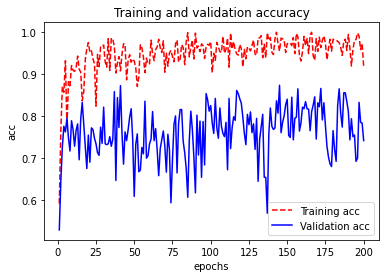

<Figure size 432x288 with 0 Axes>

In [19]:
acc = train_auc
val_acc = val_auc

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

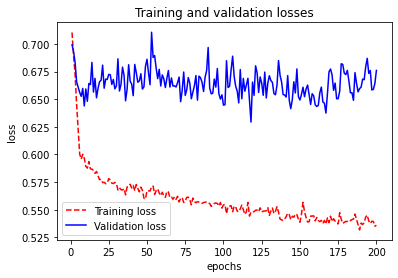

<Figure size 432x288 with 0 Axes>

In [20]:
acc = train_losses
val_acc = test_losses

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training loss'  )
plt.plot ( epochs, val_acc,  'b', label='Validation loss')
plt.title ('Training and validation losses')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [21]:
accuracy_dataframe = pd.DataFrame({"train_auc":train_auc, "val_auc":val_auc})
accuracy_dataframe.to_csv(dataframes_path + "Pesos VGG16DA/AccuracyDataframe.csv", index=False)
losses_dataframe = pd.DataFrame({"train_auc":train_losses, "val_auc":test_losses})
losses_dataframe.to_csv(dataframes_path +"Pesos VGG16DA/LossesDataFrame.csv", index=False)

In [22]:
accuracy_dataframe.sort_values(by=['val_auc'], ascending=False)

,train_auc,val_auc
144,0.955034,0.873814
40,0.907908,0.872865
171,0.963542,0.866224
156,0.989163,0.865275
183,0.975108,0.865275
...,...,...
49,0.931373,0.609108
84,0.998958,0.607211
73,0.956863,0.593928
136,0.999022,0.569260


In [16]:
batch_size = 16

In [26]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load(dataframes_path + 'Pesos VGG16DA/vgg16_weights_140.pt')
# checkpoint = torch.load(dataframes_path + 'Pesos Vgg16/vgg16_weights_195.pt',map_location ='cpu')

model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = ("cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    #print(pred)
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [27]:
submission = pd.DataFrame({"image_name":fn_list, "target":pred_list})
submission.to_csv(dataframes_path + "Pesos VGG16DA/Submission.csv", index=False)

In [28]:
df_test = pd.read_csv(dataframes_path + "test.csv")
df_merge = pd.merge(df_test, submission, left_index=True, right_index=True)

print("------------Matriz de confusión-------------------")
print(confusion_matrix(df_merge['target_x'], df_merge['target_y']))

print("------------Exactitud-------------------")
print(accuracy_score(df_merge['target_x'], df_merge['target_y']))

print("------------Precision-------------------")
print(precision_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(precision_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------Sensibilidad-------------------")
print(recall_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(recall_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------F1 score-------------------")
print(f1_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(f1_score(df_merge['target_x'], df_merge['target_y'], average=None))

------------Matriz de confusión-------------------
[[236  42]
 [115 148]]
------------Exactitud-------------------
0.7097966728280961
------------Precision-------------------
0.724178441427201
[0.67236467 0.77894737]
------------Sensibilidad-------------------
0.7097966728280961
[0.84892086 0.56273764]
------------F1 score-------------------
0.7032539417199835
[0.75039746 0.65342163]
